# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    info = get_yaml(name, 'info.yaml')
    res['jobid'] = info['jobid']
    oarstat = get_yaml(name, 'oarstat.yaml')
    date = pandas.to_datetime(oarstat['startTime'], unit='s').date()
    res['date'] = date
    res['month'] = f'{date.year}-{date.month:02}'
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    return result

simulation_dir = 'factor_exp/3/'
simulation_files = [os.path.join(simulation_dir, f) for f in os.listdir(simulation_dir) if f.endswith('.zip')]
reality_dirs = ['../hpl/factor_exp/2', '../hpl/factor_exp/3']
reality_files = [os.path.join(d, f) for d in reality_dirs for f in os.listdir(d)]


dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfsim['mode'] = 'Simulation'

dfreal = pandas.concat([read_result(f) for f in reality_files])
dfreal['mode'] = 'Reality'

df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,...,filename,model,mode,residual,start_timestamp,stop_timestamp,start,jobid,date,month
0,250000,128,32,32,1,2,0,0,1,8,...,factor_exp/3/nancy_2020-09-23_2721278.zip,hp,Simulation,NaN,NaT,NaN,NaT,NaN,NaN,NaN
1,250000,128,32,32,1,2,0,0,2,8,...,factor_exp/3/nancy_2020-09-23_2721278.zip,hp,Simulation,NaN,NaT,NaN,NaT,NaN,NaN,NaN
2,250000,128,32,32,1,2,5,1,2,8,...,factor_exp/3/nancy_2020-09-23_2721278.zip,hp,Simulation,NaN,NaT,NaN,NaT,NaN,NaN,NaN
3,250000,128,32,32,1,2,0,0,0,8,...,factor_exp/3/nancy_2020-09-23_2721278.zip,hp,Simulation,NaN,NaT,NaN,NaT,NaN,NaN,NaN
4,250000,128,32,32,1,2,4,0,0,8,...,factor_exp/3/nancy_2020-09-23_2721278.zip,hp,Simulation,NaN,NaT,NaN,NaT,NaN,NaN,NaN


In [2]:
csv_columns =  ['filename', 'matrix_size', 'gflops', 'time', 'mode']
csv_columns += ['bcast', 'block_size', 'depth', 'swap', 'pfact', 'rfact']
df[csv_columns].to_csv('/tmp/hpl_factorial.csv', index=False)

### Checking the parameters

In [3]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes', 'jobid', 'date', 'start', 'month',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,bcast,pfact,proc_p,mem_align,swap,rfact,process_per_node,thread_per_process,proc_q,block_size,depth
0,0,1,32,8,1,2,32,1,32,128,0
1,0,1,32,8,2,2,32,1,32,128,0
2,5,1,32,8,2,2,32,1,32,128,1
3,0,1,32,8,0,2,32,1,32,128,0
4,4,1,32,8,0,2,32,1,32,128,0
...,...,...,...,...,...,...,...,...,...,...,...
31,3,1,32,8,2,2,32,1,32,128,0
35,4,1,32,8,2,2,32,1,32,128,1
36,3,1,32,8,0,2,32,1,32,128,1
40,1,1,32,8,1,2,32,1,32,128,0


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu_ringrong_fixed_no-TCP-gamma.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="network/weight-S" value="0"/>
        <prop id="network/crosstraffic" value="false"/>
        <prop id="maxmin/precision" value="1e-09"/>
        <prop id="surf/precision" value="1e-12"/>
        <prop id="maxmin/concurrency-limit" value="-1"/>
        <prop id="smpi/os" value="0:1.0390044058501086e-06:2.2582693391522874e-11;8000:0.0003468233639105082:0.0;15798:0.0002888553072948145:2.3011264127198946e-09;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.1606281334276814e-06:2.5405126421726545e-11;8000:4.813055334777501e-07:1.3709188743427587e-10;15798:6.405086625588439e-07:1.4914447755480297e-10;64000:0.0:0.0;6000000:0.0:0.0;42672591:0.0:0.0;160097505:0.0:0.0"/>
        <prop id="smpi/ois" value="0:9.114127576191782e-07:7.635116667577744e-11;8000:7.532902626587861e-07:1.0157330626986557e-10;15798:4.213616239765202e-06:3.022067854930598e-11;64000:1.0982098510875872e-06:5.530436066901923e-14;6000000:1.167813671168556e-06:4.632525436311795e-14;42672591:3.151147394741291e-06:5.11470100892252e-16;160097505:3.232961654323926e-06:2.553537399274677e-16"/>
        <prop id="smpi/bw-factor" value="0:1.0000000000000002;8000:1.0000000000000002;15798:0.07435006650635523;64000:0.3163352696348148;6000000:0.13003278960133288;42672591:0.10354740223279707;160097505:0.40258935729656503"/>
        <prop id="smpi/lat-factor" value="0:0.0;8000:1731.7102918851567;15798:1441.073993161278;64000:1761.4784830658123;6000000:0.0;42672591:0.0;160097505:970913.4558162984"/>
        <prop id="smpi/loopback-bw-factor" value="0:0.17591906192813994;16000:0.12119203247138953;6000000:0.07551057012803415;36900419:0.04281516758309203;160097505:0.17440518795992602"/>
        <prop id="smpi/loopback-lat-factor" value="0:0.0;16000:650.2212383180362;6000000:0.0;36900419:0.0;160097505:1017885.3518765072"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.5197820823244545e-07"/>
        <prop id="smpi/test" value="8.273395731280616e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="1-32" speed="1" core="32" bw="12.5GBps" lat="0.10us" loopback_bw="25.0GBps" loopback_lat="0.10us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [5]:
patches = set()
for row in dfsim.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/pgesv/HPL_pdgesv.c b/src/pgesv/HPL_pdgesv.c
index af46ee6..c5574c1 100644
--- a/src/pgesv/HPL_pdgesv.c
+++ b/src/pgesv/HPL_pdgesv.c
@@ -94,6 +94,8 @@ void HPL_pdgesv
 /* ..
  * .. Executable Statements ..
  */
+   timestamp_t start = get_timestamp();
+   timestamp_t duration;
    if( A->n <= 0 ) return;

    A->info = 0;
@@ -110,6 +112,8 @@ void HPL_pdgesv
  * Solve upper triangular system
  */
    if( A->info == 0 ) HPL_pdtrsv( GRID, A );
+   duration = get_timestamp() - start;
+   record_measure(__FILE__, __LINE__, "HPL_pdgesv", start, duration, 0, NULL);
 /*
  * End of HPL_pdgesv
  */
diff --git a/src/pgesv/HPL_pdupdateTT.c b/src/pgesv/HPL_pdupdateTT.c
index 57444bc..b990903 100644
--- a/src/pgesv/HPL_pdupdateTT.c
+++ b/src/pgesv/HPL_pdupdateTT.c
@@ -113,6 +113,8 @@ void HPL_pdupdateTT
 /* ..
  * .. Executable Statements ..
  */
+   timestamp_t start_pduptate = get_timestamp();
+   timestamp_t duration;
 #ifdef HPL_DETAILED_TIMING
    HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
@@ -125,18 +127,26 @@ void HPL_pdupdateTT
    {
       if( PBCST != NULL )
       {
+         timestamp_t start_bcast = get_timestamp();
          do { (void) HPL_bcast( PBCST, IFLAG ); }
          while( *IFLAG != HPL_SUCCESS );
+         timestamp_t duration = get_timestamp() - start_bcast;
+         record_measure(__FILE__, __LINE__, "first_bcast", start_bcast, duration, 0, NULL);
       }
 #ifdef HPL_DETAILED_TIMING
       HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
+      duration = get_timestamp() - start_pduptate;
+      record_measure(__FILE__, __LINE__, "HPL_pdupdateTT", start_pduptate, duration, 0, NULL);
       return;
    }
 /*
  * Enable/disable the column panel probing mechanism
  */
+   timestamp_t start_bcast2 = get_timestamp();
    (void) HPL_bcast( PBCST, &test );
+   duration = get_timestamp() - start_bcast2;
+   record_measure(__FILE__, __LINE__, "second_bcast", start_bcast2, duration, 0, NULL);
 /*
  * 1 x Q case
  */
@@ -437,6 +447,8 @@ void HPL_pdupdateTT
 #ifdef HPL_DETAILED_TIMING
    HPL_ptimer( HPL_TIMING_UPDATE );
 #endif
+   duration = get_timestamp() - start_pduptate;
+   record_measure(__FILE__, __LINE__, "HPL_pdupdateTT", start_pduptate, duration, 0, NULL);
 /*
  * End of HPL_pdupdateTT
  */

```

### Checking that the real run has no temporal pattern

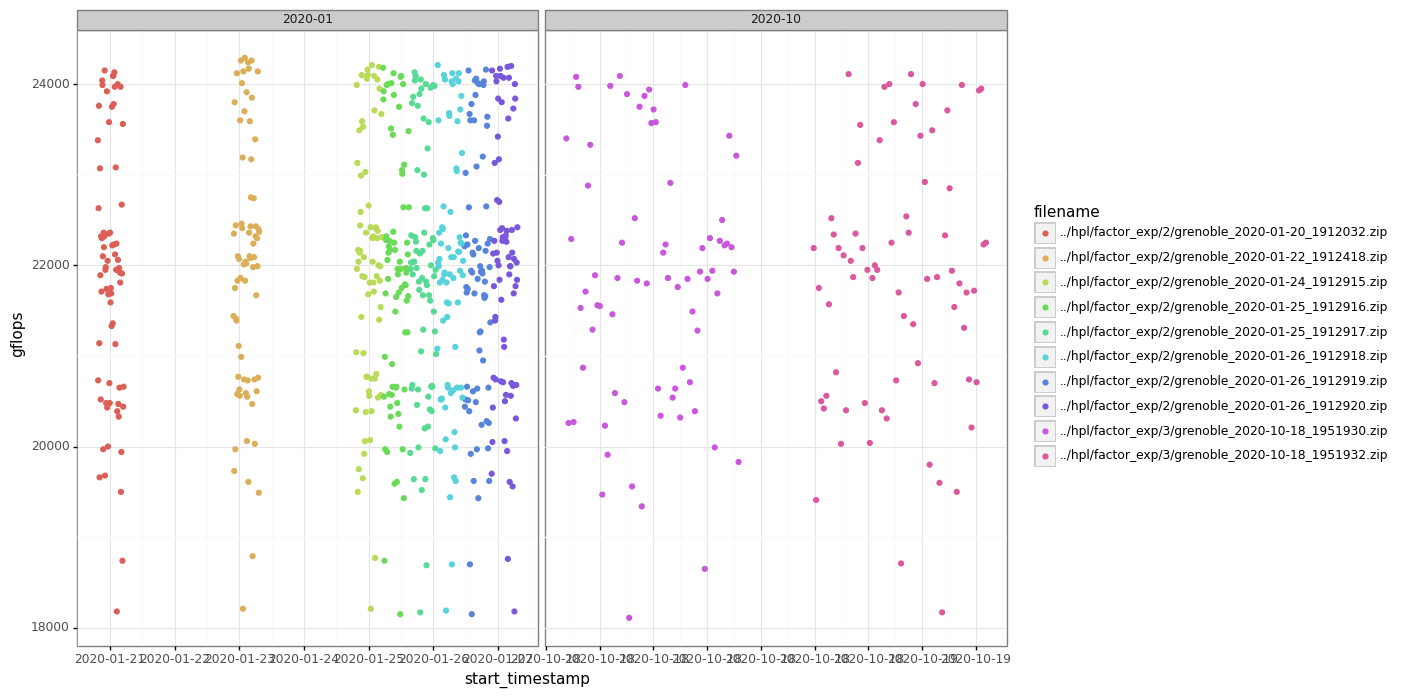

<ggplot: (8771271242546)>

In [6]:
ggplot(dfreal, aes(x='start_timestamp', y='gflops', color='filename')) + geom_point() + theme_bw() + facet_wrap('month', scales='free_x')

### Comparing the real experiments

First, let's have a look at the different real experiments. Some of them were done a long time ago, some of them are very recent. Do we have similar performance?

In [7]:
factors = ['swap', 'bcast', 'depth', 'block_size']
dfreal['fact'] = ''
for f in factors:
    dfreal['fact'] += ':' + dfreal[f].astype(str)

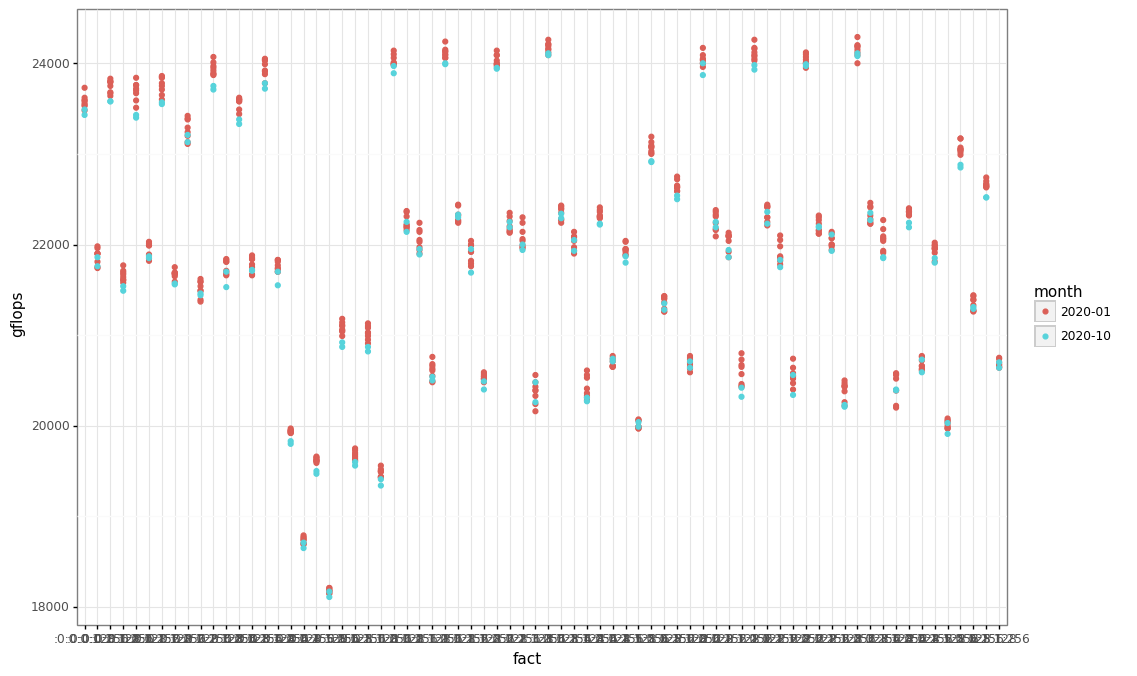

<ggplot: (8771169589957)>

In [8]:
(ggplot(dfreal)
    + aes(x='fact', y='gflops', color='month')
    + geom_point()
    + theme_bw()
)

### Prediction error for individual factor combinations

In [9]:
factors = ['swap', 'bcast', 'depth', 'block_size']

In [10]:
grouped_real = dfreal.groupby(factors)[['gflops']].mean()
comparison = grouped_real.join(dfsim.set_index(factors), how='outer', lsuffix='_reality', rsuffix='_simulation').reset_index()
comparison['error'] = (comparison['gflops_simulation'] - comparison['gflops_reality'])/comparison['gflops_reality'] * 100

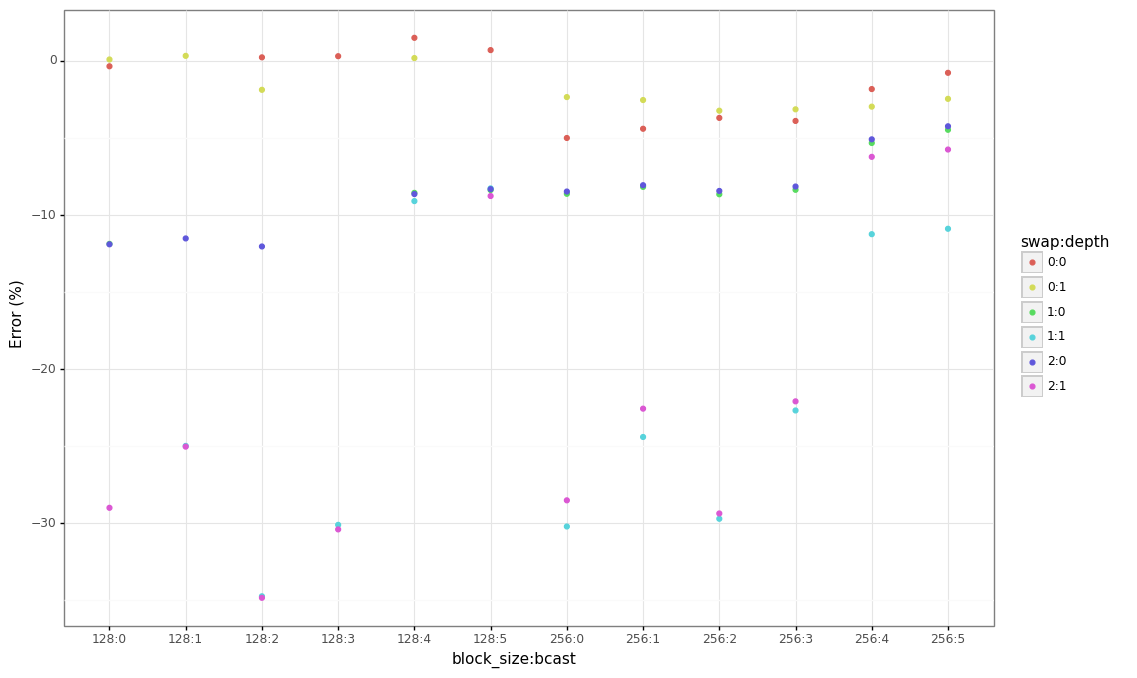

<ggplot: (-9223363265677856694)>

In [11]:
def do_plot(df, y, x_factors, x_colors, jitter=False):
    tmp = df.copy()
    xfact = ':'.join(x_factors)
    xcol = ':'.join(x_colors)
    tmp[xfact] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_factors), axis=1)
    tmp[xcol] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_colors), axis=1)
    plot = ggplot(tmp, aes(x=xfact, y=y, color=xcol)) + theme_bw()
    if jitter:
        plot += geom_jitter()
    else:
        plot += geom_point()
    return plot

do_plot(comparison, 'error', ['block_size', 'bcast'], ['swap', 'depth']) + ylab('Error (%)')

In [12]:
comparison[['error']].describe()

,error
count,63.000000
mean,-10.824867
std,10.410539
min,-34.833908
25%,-11.980180
50%,-8.332971
75%,-3.200582
max,1.481296


In [13]:
for thresh in range(1, 6):
    nb = len(comparison[(comparison['error'] > -thresh) & (comparison['error'] < thresh)])
    print('%2d simulations with an error between -%d%% and %d%%' % (nb, thresh, thresh))

 8 simulations with an error between -1% and 1%
11 simulations with an error between -2% and 2%
15 simulations with an error between -3% and 3%
19 simulations with an error between -4% and 4%
22 simulations with an error between -5% and 5%


In [14]:
comparison['abs_error'] = comparison['error'].abs()
comparison.sort_values(by='abs_error', ascending=False).head(n=10)[factors + ['error']]

,swap,bcast,depth,block_size,error
58,2,2,1,128,-34.833908
34,1,2,1,128,-34.735315
62,2,3,1,128,-30.397276
27,1,0,1,256,-30.208839
38,1,3,1,128,-30.102643
35,1,2,1,256,-29.707442
59,2,2,1,256,-29.364378
50,2,0,1,128,-28.996502
51,2,0,1,256,-28.512336
54,2,1,1,128,-25.030837


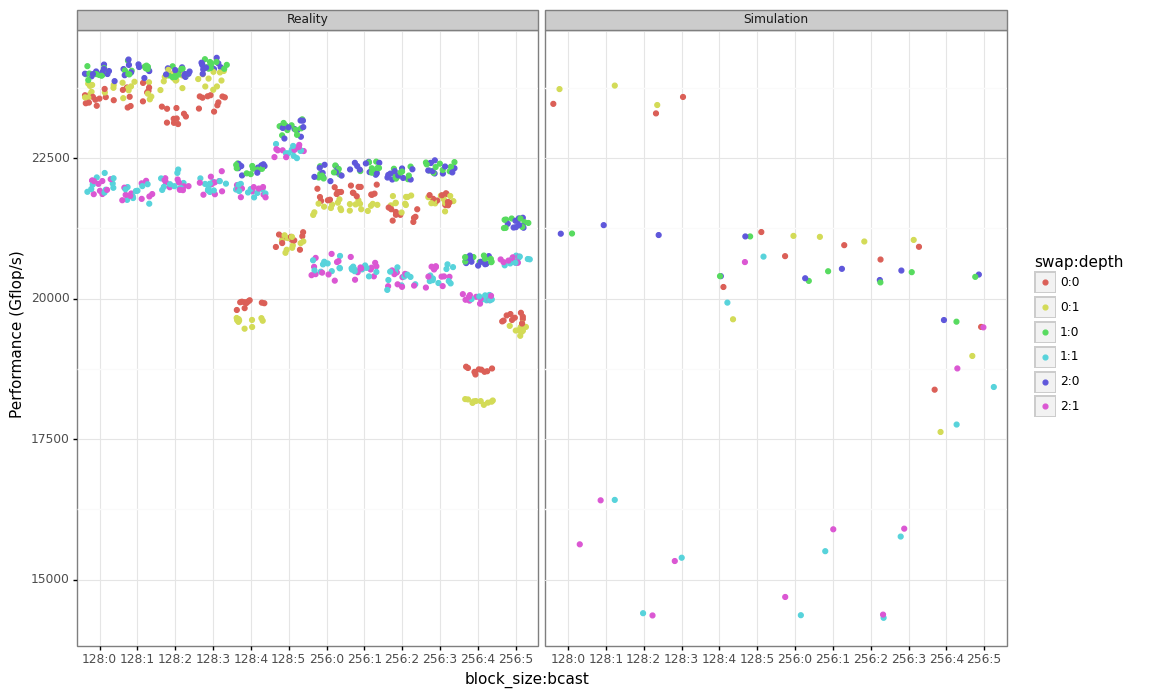

<ggplot: (-9223363265684584893)>

In [15]:
do_plot(df, 'gflops', ['block_size', 'bcast'], ['swap', 'depth'], jitter=True) + ylab('Performance (Gflop/s)') + facet_wrap('mode')

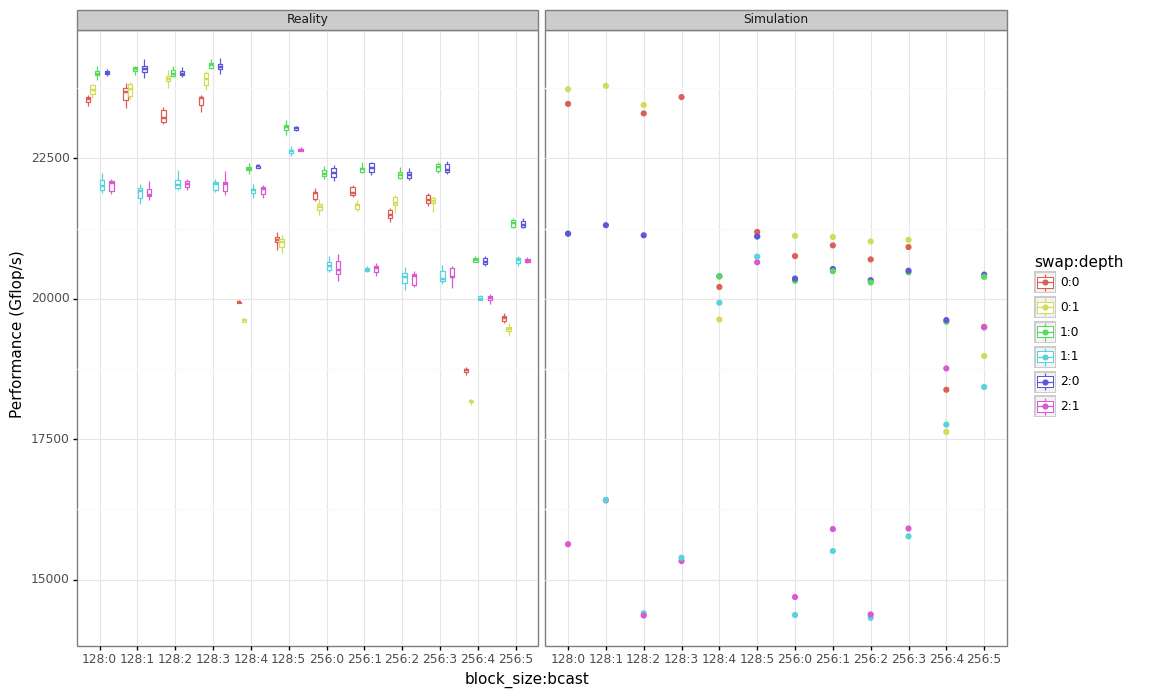

<ggplot: (-9223363265684975125)>

In [16]:
tmp = df.copy()
x_factors = ['block_size', 'bcast']
x_colors = ['swap', 'depth']
xfact = ':'.join(x_factors)
xcol = ':'.join(x_colors)
tmp[xfact] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_factors), axis=1)
tmp[xcol] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_colors), axis=1)
plot = ggplot(tmp, aes(x=xfact, y='gflops', color=xcol)) + theme_bw()
plot = plot + geom_boxplot(tmp[tmp['mode'] == 'Reality'], outlier_alpha=0) + geom_point(tmp[tmp['mode'] == 'Simulation'])
plot = plot + ylab('Performance (Gflop/s)') + facet_wrap('mode')
plot

### Simulation efficiency

In [17]:
dfsim.simulation_time.describe()

count      63.000000
mean     6010.558095
std      1678.513737
min      3192.640000
25%      4920.650000
50%      6088.950000
75%      7215.710000
max      9537.820000
Name: simulation_time, dtype: float64

In [18]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def my_anova(df, factors, response, two_way=True):
    f_str = ['C(%s)' % fact for fact in factors if len(df[fact].unique()) > 1]
    formula = ' + '.join(f_str)
    if two_way:
        formula = '(%s)**2' % formula
    formula = '%s ~ %s' % (response, formula)
    print(formula)
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)
    aov_table['stars'] = ''
    aov_table.loc[aov_table['PR(>F)'] < 0.1 ,  'stars'] = '.'
    aov_table.loc[aov_table['PR(>F)'] < 0.05,  'stars'] = '*'
    aov_table.loc[aov_table['PR(>F)'] < 0.01,  'stars'] = '**'
    aov_table.loc[aov_table['PR(>F)'] < 0.001, 'stars'] = '***'
    return aov_table

In [19]:
my_anova(dfsim, factors, 'simulation_time').sort_values(by='F', ascending=False)

simulation_time ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(depth),2.842302e+07,1.0,242.787043,2.511612e-15,***
C(block_size),2.261774e+07,1.0,193.198843,4.315696e-14,***
C(bcast),7.837541e+07,5.0,133.895239,1.194118e-18,***
C(swap),1.878441e+07,2.0,80.227439,2.554519e-12,***
C(bcast):C(depth),1.295999e+07,5.0,22.140635,6.111784e-09,***
C(swap):C(depth),4.330583e+06,2.0,18.495738,7.589668e-06,***
C(swap):C(block_size),1.068822e+06,2.0,4.564896,1.923522e-02,*
C(swap):C(bcast),4.685169e+06,10.0,4.002032,1.784311e-03,**
C(depth):C(block_size),1.777120e+05,1.0,1.518001,2.281690e-01,
C(bcast):C(block_size),1.627299e+05,5.0,0.278005,9.212740e-01,


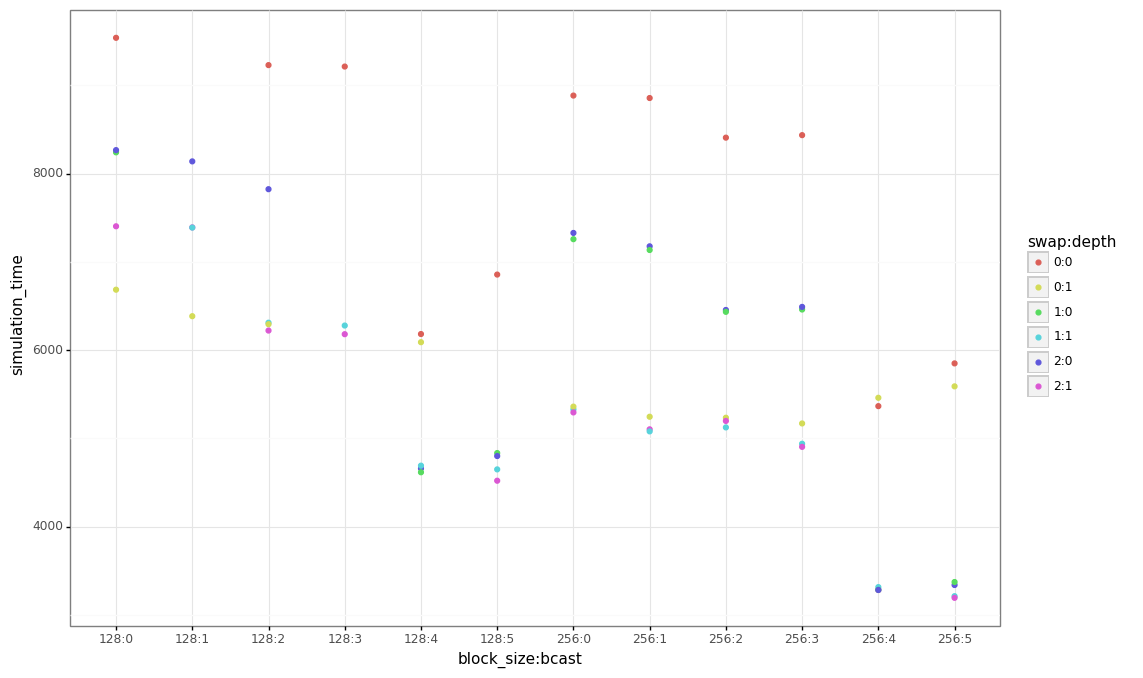

<ggplot: (8771167931186)>

In [20]:
do_plot(dfsim, 'simulation_time', ['block_size', 'bcast'], ['swap', 'depth'])

In [21]:
dfsim.simulation_time.sum() / 3600

105.18476666666668

In [22]:
dfsim.application_time.sum() / 3600

17.573769444444448

In [23]:
len(dfsim)

63

### Comparing the simulation with the real execution - ANOVA

In [24]:
my_anova(dfreal, factors, 'gflops').sort_values(by='F', ascending=False)

gflops ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(block_size),5.321165e+08,1.0,8261.830571,0.000000e+00,***
C(depth),1.750446e+08,1.0,2717.804772,1.265970e-240,***
C(bcast),3.636182e+08,5.0,1129.133170,0.000000e+00,***
C(swap):C(depth),8.540520e+07,2.0,663.015808,6.354013e-161,***
C(swap):C(bcast),2.029502e+08,10.0,315.107797,1.489431e-248,***
C(swap),1.488747e+07,2.0,115.574080,5.633314e-44,***
C(bcast):C(depth),2.701105e+07,5.0,83.876635,1.019891e-68,***
C(bcast):C(block_size),8.662807e+05,5.0,2.690037,2.031933e-02,*
C(depth):C(block_size),1.102613e+05,1.0,1.711956,1.911707e-01,
C(swap):C(block_size),6.395861e+04,2.0,0.496522,6.088626e-01,


In [25]:
my_anova(dfsim, factors, 'gflops').sort_values(by='F', ascending=False)

gflops ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(depth),9.257426e+07,1.0,111.527384,2.847979e-11,***
C(swap),9.233148e+07,2.0,55.617453,1.769044e-10,***
C(swap):C(depth),4.891018e+07,2.0,29.461888,1.295007e-07,***
C(block_size),2.376370e+07,1.0,28.628948,1.064283e-05,***
C(swap):C(block_size),1.256876e+07,2.0,7.571010,2.352913e-03,**
C(bcast):C(depth),2.820116e+07,5.0,6.794982,2.910388e-04,***
C(swap):C(bcast),5.638485e+07,10.0,6.792876,2.804373e-05,***
C(bcast),1.550958e+07,5.0,3.736984,1.022151e-02,*
C(bcast):C(block_size),3.015592e+06,5.0,0.726598,6.093044e-01,
C(depth):C(block_size),1.862587e+05,1.0,0.224392,6.393862e-01,


### Comparing the simulation with the real execution - graphically

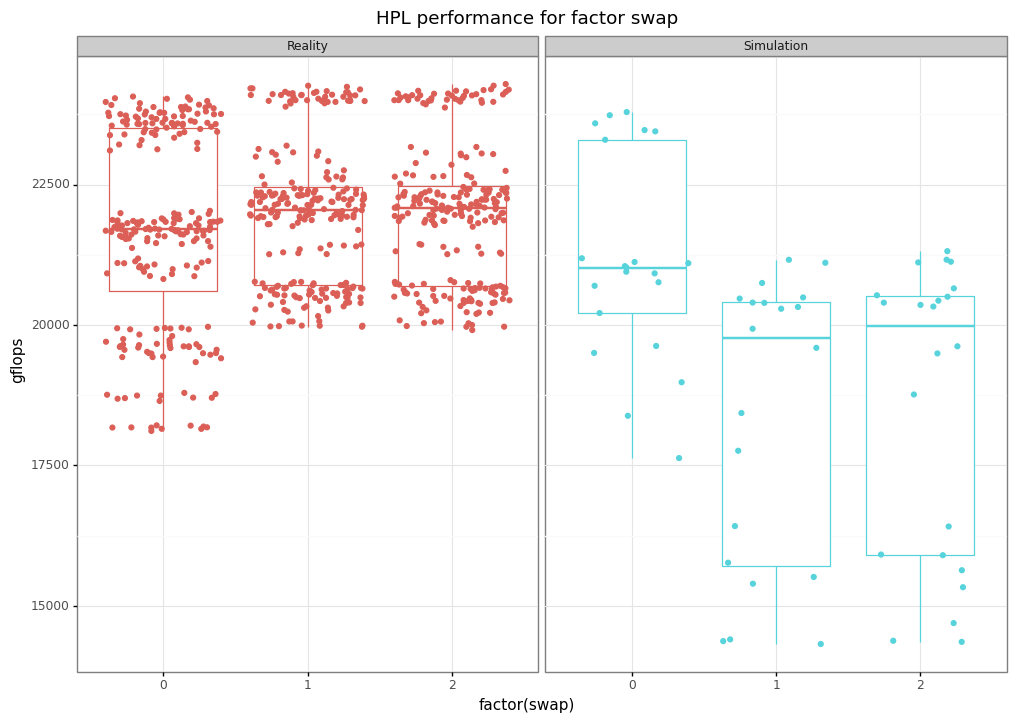

<ggplot: (8771167931389)>


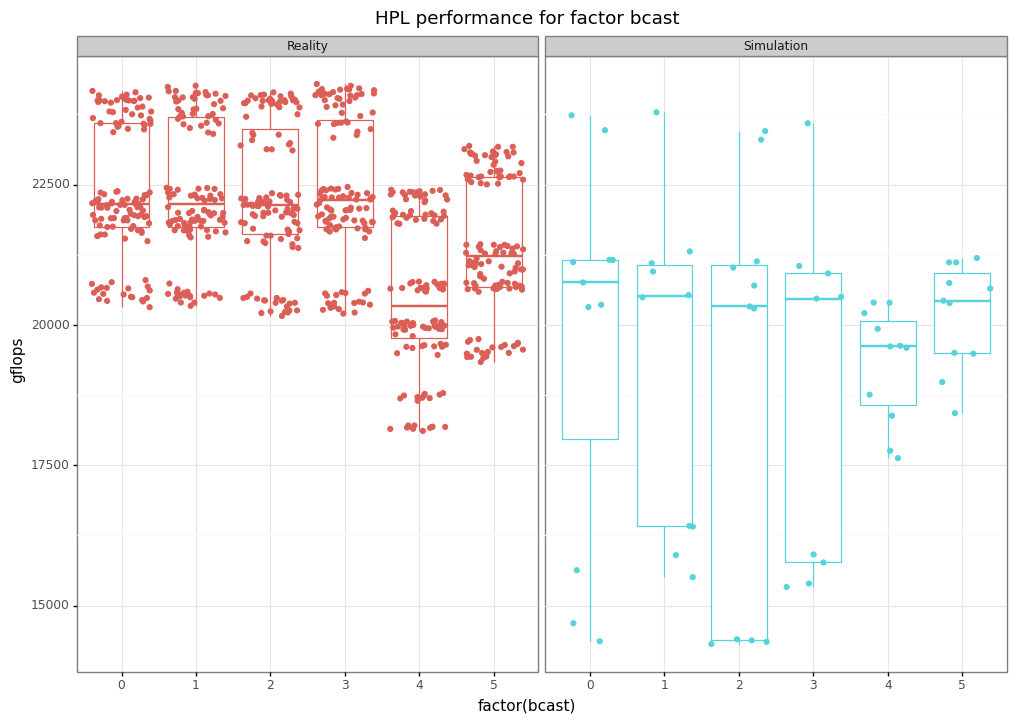

<ggplot: (-9223363265677839833)>


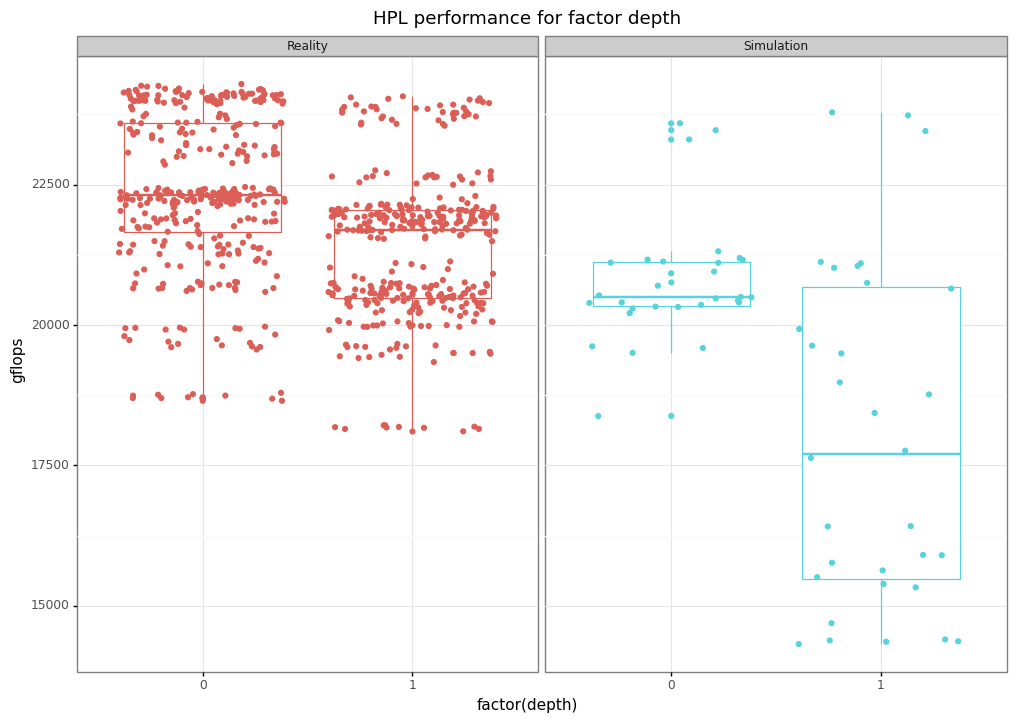

<ggplot: (-9223363265684514076)>


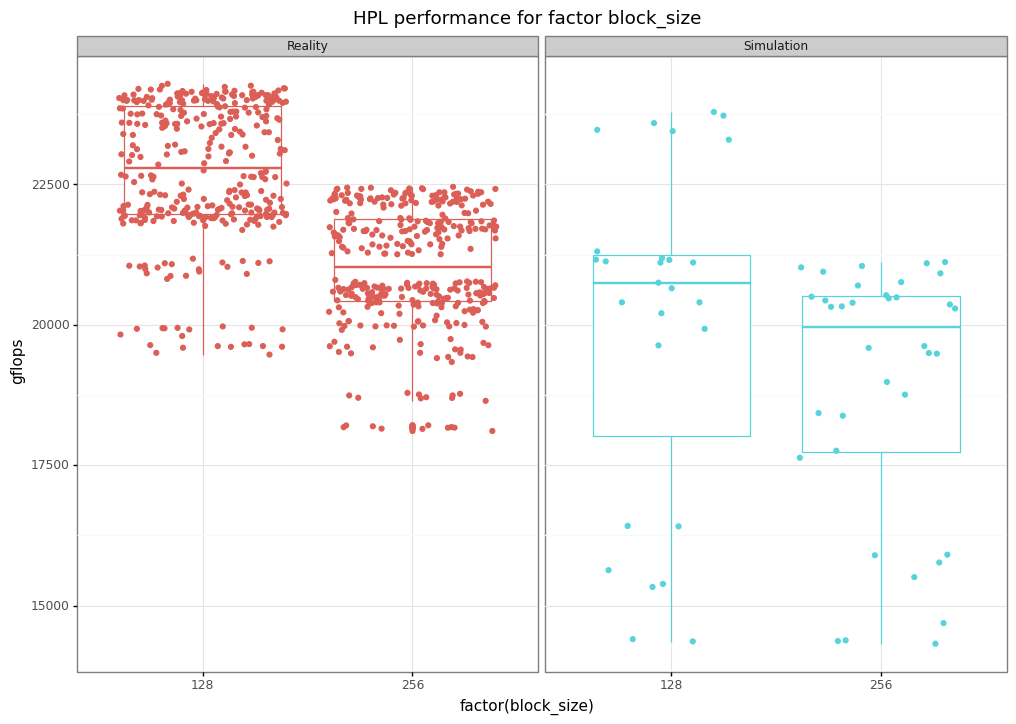

<ggplot: (8771172541686)>


In [26]:
for fact in factors:
    plot = ggplot(df, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none') + ggtitle('HPL performance for factor %s' % fact)
    plot = plot + geom_jitter()
    print(plot)

### Choosing iteratively the best combination (based on the simulation)

In [27]:
def performance_anova(df):
    if len(df[df['mode'] == 'Simulation']) >= 30:
        print('Performing a two-way ANOVA')
        return my_anova(df[df['mode'] == 'Simulation'], factors, 'gflops').sort_values(by='F', ascending=False)
    else:
        print('Performing a one-way ANOVA')
        return my_anova(df[df['mode'] == 'Simulation'], factors, 'gflops', two_way=False).sort_values(by='F', ascending=False)

In [28]:
def anova_plot(df, fact):
    plot = ggplot(df, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + theme_bw() + facet_wrap('mode') + theme(legend_position='none')
    plot = plot + ggtitle('HPL performance for factor %s' % fact)
    if len(df[df['mode'] == 'Simulation']) >= 30:
        plot = plot + geom_boxplot() + geom_jitter()
    else:
        plot += geom_point()
    return plot

In [29]:
tmp = df[factors + ['gflops', 'mode']]
performance_anova(tmp)

Performing a two-way ANOVA
gflops ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(depth),9.257426e+07,1.0,111.527384,2.847979e-11,***
C(swap),9.233148e+07,2.0,55.617453,1.769044e-10,***
C(swap):C(depth),4.891018e+07,2.0,29.461888,1.295007e-07,***
C(block_size),2.376370e+07,1.0,28.628948,1.064283e-05,***
C(swap):C(block_size),1.256876e+07,2.0,7.571010,2.352913e-03,**
C(bcast):C(depth),2.820116e+07,5.0,6.794982,2.910388e-04,***
C(swap):C(bcast),5.638485e+07,10.0,6.792876,2.804373e-05,***
C(bcast),1.550958e+07,5.0,3.736984,1.022151e-02,*
C(bcast):C(block_size),3.015592e+06,5.0,0.726598,6.093044e-01,
C(depth):C(block_size),1.862587e+05,1.0,0.224392,6.393862e-01,


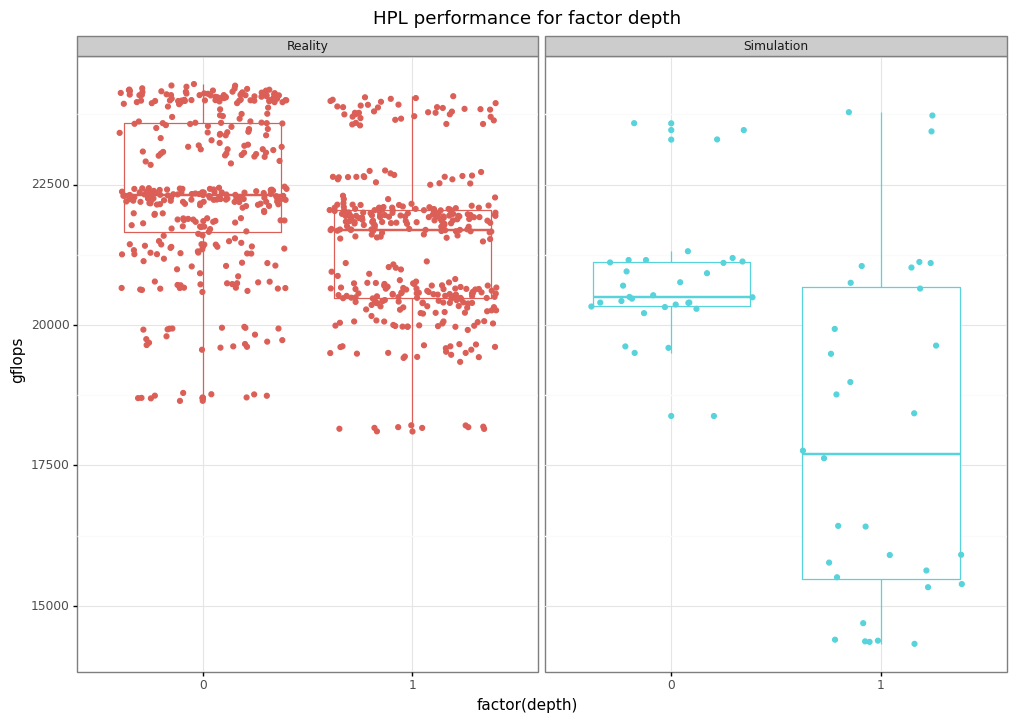

<ggplot: (-9223363265684479898)>

In [30]:
anova_plot(tmp, 'depth')

In [31]:
tmp = tmp[tmp.depth == 0]
performance_anova(tmp)

Performing a two-way ANOVA
gflops ~ (C(swap) + C(bcast) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(block_size),1.206323e+07,1.0,281.760757,0.000014,***
C(bcast),1.085138e+07,5.0,50.691078,0.000277,***
C(swap):C(block_size),2.471431e+06,2.0,28.862588,0.001794,**
C(swap):C(bcast),5.074380e+06,10.0,11.852220,0.006881,**
C(swap),8.059235e+05,2.0,9.411971,0.020179,*
C(bcast):C(block_size),2.888712e+05,5.0,1.349432,0.375145,
Residual,2.140688e+05,5.0,NaN,NaN,


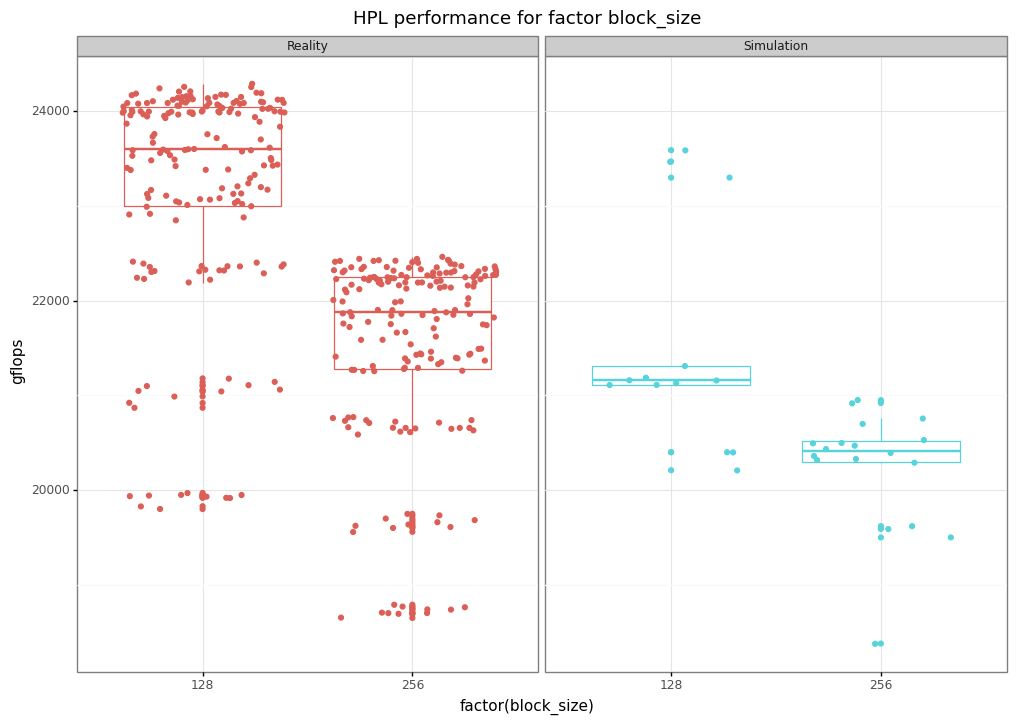

<ggplot: (8771170014258)>

In [32]:
anova_plot(tmp, 'block_size')

In [33]:
tmp = tmp[tmp.block_size == 128]
performance_anova(tmp)

Performing a one-way ANOVA
gflops ~ C(swap) + C(bcast)


,sum_sq,df,F,PR(>F),stars
C(bcast),7.205178e+06,5.0,2.193903,0.204398,
C(swap),2.656001e+06,2.0,2.021814,0.227284,
Residual,3.284182e+06,5.0,NaN,NaN,


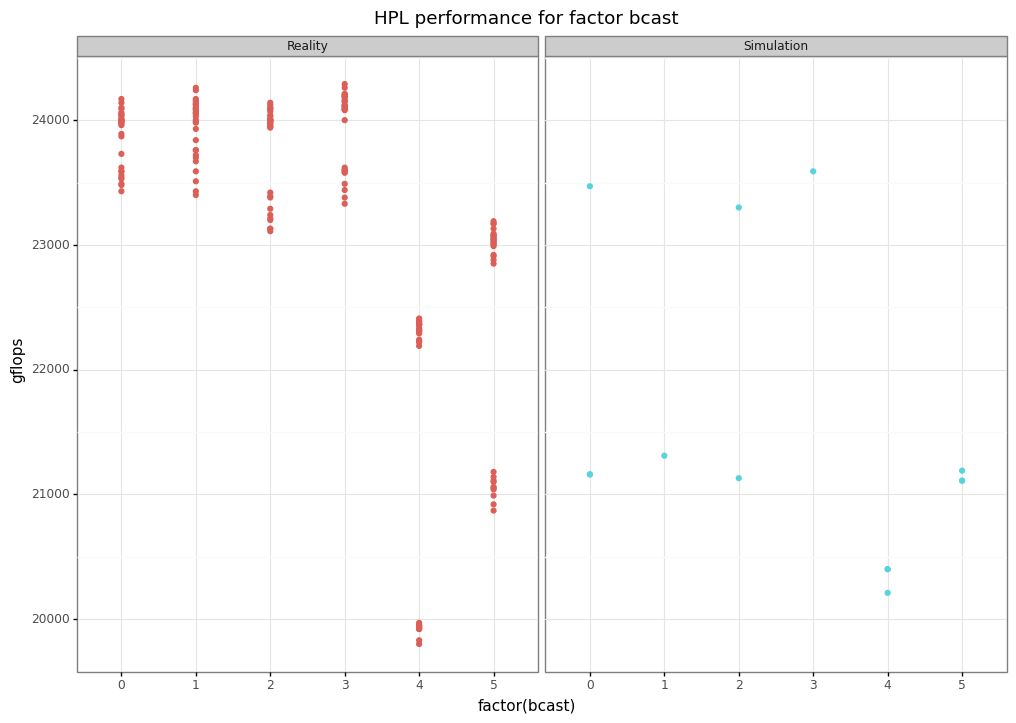

<ggplot: (8771170039549)>

In [34]:
anova_plot(tmp, 'bcast')

In [35]:
tmp = tmp[tmp.bcast.isin([0, 2, 3])]
performance_anova(tmp)

Performing a one-way ANOVA
gflops ~ C(swap) + C(bcast)


,sum_sq,df,F,PR(>F),stars
C(swap),5.906950e+06,2.0,602.750000,0.028790,*
C(bcast),3.801667e+04,2.0,3.879252,0.337898,
Residual,4.900000e+03,1.0,NaN,NaN,


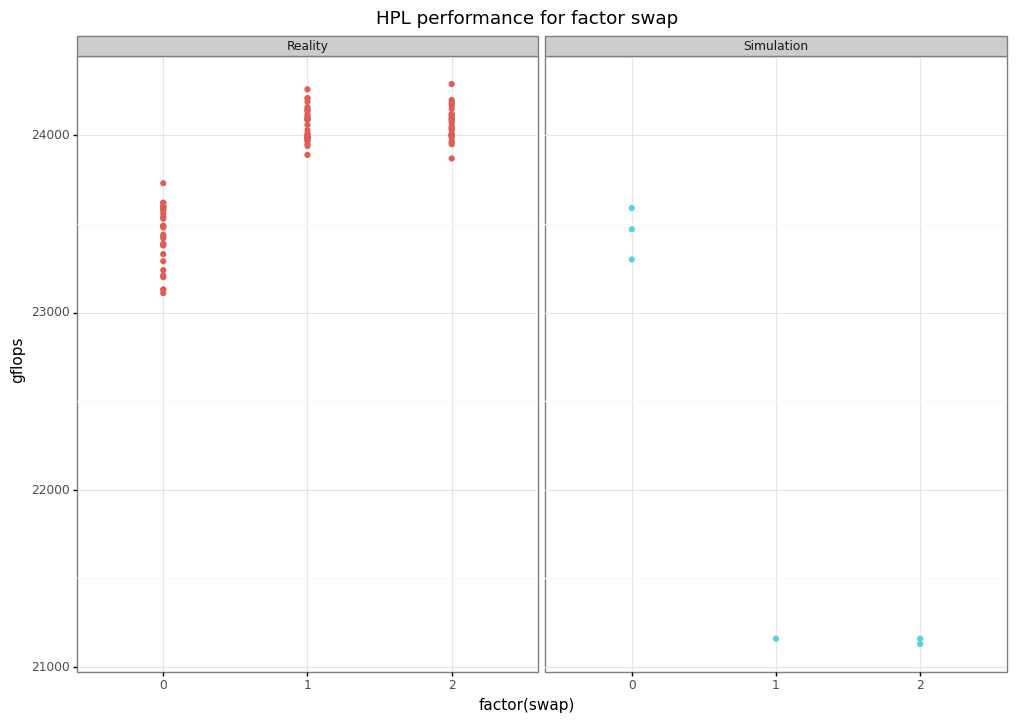

<ggplot: (8771170207047)>

In [36]:
anova_plot(tmp, 'swap')

In [37]:
tmp = tmp[tmp.swap.isin([0])]

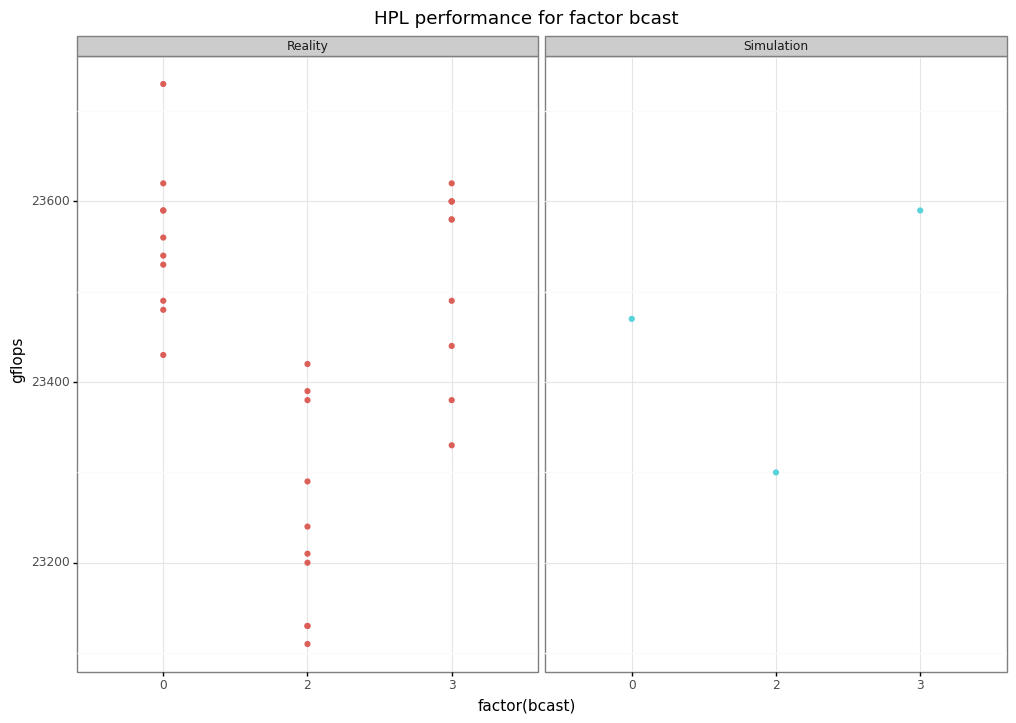

<ggplot: (8771170263858)>

In [38]:
anova_plot(tmp, 'bcast')

In [39]:
tmp = tmp[tmp.bcast == 3]

In [40]:
tmp[tmp['mode'] == 'Simulation'].sort_values(by='gflops', ascending=False)

,swap,bcast,depth,block_size,gflops,mode
4,0,3,0,128,23590.0,Simulation


In [41]:
tmp[tmp['mode'] == 'Reality'].sort_values(by='gflops', ascending=False)

,swap,bcast,depth,block_size,gflops,mode
46,0,3,0,128,23620.0,Reality
18,0,3,0,128,23600.0,Reality
26,0,3,0,128,23600.0,Reality
3,0,3,0,128,23600.0,Reality
31,0,3,0,128,23580.0,Reality
51,0,3,0,128,23580.0,Reality
9,0,3,0,128,23490.0,Reality
27,0,3,0,128,23440.0,Reality
27,0,3,0,128,23380.0,Reality
10,0,3,0,128,23330.0,Reality


In [42]:
tmp[tmp['mode'] == 'Reality']['gflops'].describe()

count       10.000000
mean     23522.000000
std        105.071404
min      23330.000000
25%      23452.500000
50%      23580.000000
75%      23600.000000
max      23620.000000
Name: gflops, dtype: float64

In [43]:
df[df['mode'] == 'Reality'].gflops.describe(percentiles=[.1, .25, .5, .75, .9])

count      720.000000
mean     21893.180556
std       1418.236194
min      18110.000000
10%      20030.000000
25%      20700.000000
50%      21960.000000
75%      22775.000000
90%      23990.000000
max      24290.000000
Name: gflops, dtype: float64

In [44]:
df[df['mode'] == 'Reality'][factors + ['time', 'gflops']].sort_values(by='gflops', ascending=False).head(n=5)

,swap,bcast,depth,block_size,time,gflops
31,2,3,0,128,428.92,24290.0
50,2,1,0,128,429.34,24260.0
20,1,3,0,128,429.39,24260.0
40,1,1,0,128,429.82,24240.0
1,1,3,0,128,430.32,24210.0


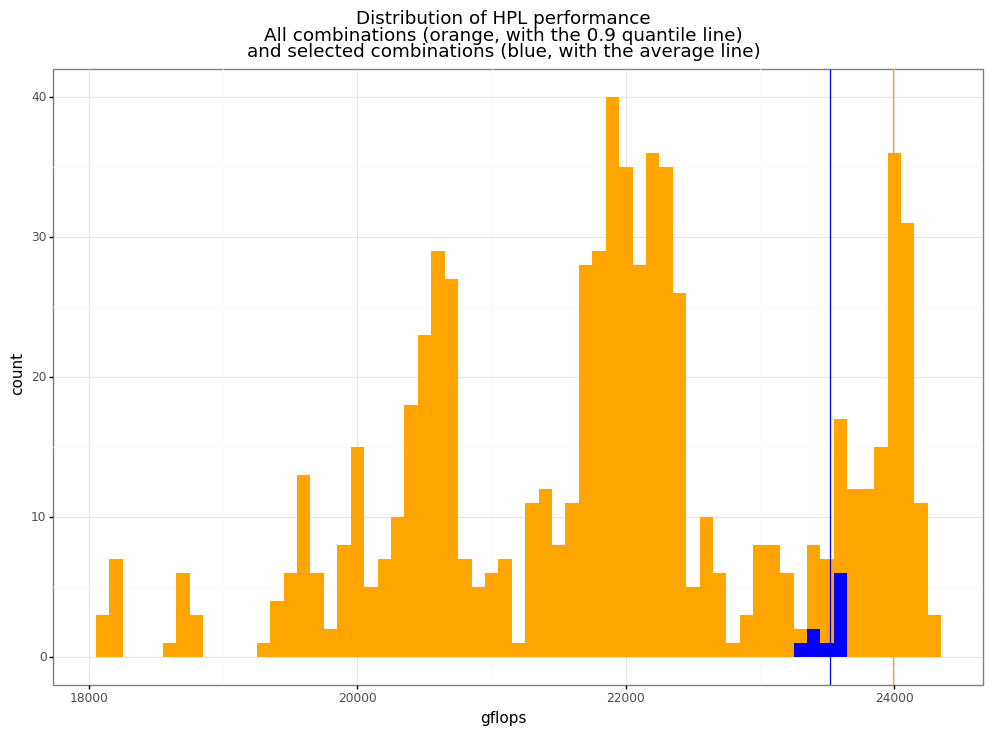

<ggplot: (8771169925668)>

In [45]:
tmpreal = tmp[tmp['mode'] == 'Reality']
binwidth=100
plot = ggplot(aes(x='gflops')) + geom_histogram(dfreal, binwidth=binwidth, fill='orange') + geom_histogram(tmpreal, binwidth=binwidth, fill='blue') + theme_bw()
plot = plot + geom_vline(xintercept=tmpreal.gflops.mean(), color='blue') + geom_vline(xintercept=dfreal.gflops.quantile(0.9), color='orange')
plot = plot + ggtitle('Distribution of HPL performance\nAll combinations (orange, with the 0.9 quantile line)\nand selected combinations (blue, with the average line)')
plot